In [1]:
from lstmad.vrae import VRAE
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import copy

import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
import seaborn

from lstmad.lstmae import RecurrentAutoencoder, train_model

import matplotlib.pyplot as plt

RANDOM_SEED = 666

### Hyperparameters

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load data

In [3]:
train_df = pd.read_csv('data/ECG5000_TRAIN.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

test_df = pd.read_csv('data/ECG5000_TEST.txt',
                       sep=' ',skipinitialspace=True,
                       header=None,
                       names=['target'] + list(range(0,140)))

In [4]:
df = train_df.append(test_df)
df = df.sample(frac=1.0)
df.target -=1
y = df['target']
X = df.drop(labels='target', axis=1)
y = (y>1.0).astype(int)

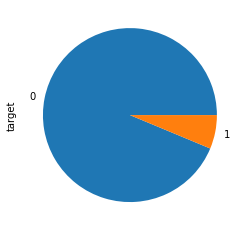

In [5]:
y.value_counts().plot.pie()

In [6]:
train_X, val_X, train_y, val_y = train_test_split(
  X, y,
  test_size=0.3,
  random_state=RANDOM_SEED
)

val_X, test_X, val_y, test_y = train_test_split(
  val_X, val_y,
  test_size=0.5, 
  random_state=RANDOM_SEED
)

In [7]:
def create_dataset(df):
    sequences = df.astype(np.float32).to_numpy().tolist()
    dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
    n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [8]:
train_dataset, seq_len, n_features = create_dataset(train_X)
val_dataset, _, _ = create_dataset(val_X)
test_dataset, _, _ = create_dataset(test_X)


In [9]:
print(f'Train dataset: {len(train_dataset)/len(X)}')
print(f'Val dataset: {len(val_dataset)/len(X)}')
print(f'Test dataset: {len(test_dataset)/len(X)}')



Train dataset: 0.7
Val dataset: 0.15
Test dataset: 0.15


In [10]:
model = RecurrentAutoencoder(seq_len, n_features, device, 8)
model = model.to(device)

In [11]:
for layer_size in [4, 8, 12, 16, 24, 32, 50, 64]:
    model = RecurrentAutoencoder(seq_len, n_features, device, layer_size)
    model = model.to(device)
    train_model(model,train_dataset,val_dataset, 150 , device)
    torch.save(model.state_dict(), f'autoencoder_{layer_size}.pkl')

Epoch 1: train loss 88.87129035622733 val loss 87.4270625406901
Epoch 2: train loss 71.3924971422468 val loss 62.063507176717124
Epoch 3: train loss 59.45429753330776 val loss 58.1422251180013
Epoch 4: train loss 56.98578654153006 val loss 54.81965076700846
Epoch 5: train loss 51.081955198015486 val loss 51.253094159444174
Epoch 6: train loss 48.470452414376396 val loss 46.49843199412028
Epoch 7: train loss 46.221771420342584 val loss 46.329912551879886
Epoch 8: train loss 45.51018943405151 val loss 48.281703384399414
Epoch 9: train loss 44.59504442650931 val loss 47.80245772043864
Epoch 10: train loss 42.724014355795724 val loss 46.28863594055176
Epoch 11: train loss 41.26125182233538 val loss 44.83970237223307
Epoch 12: train loss 41.14676085008894 val loss 39.551652378082274
Epoch 13: train loss 39.71079187093462 val loss 40.02429039255778
Epoch 14: train loss 39.33258220182147 val loss 43.29293083190918
Epoch 15: train loss 38.460470168794906 val loss 41.87498490397135
Epoch 16: tr

In [28]:
model_sizes_results = []
for model_size in [4, 8, 12, 16, 24, 32, 50, 64]:
    model = RecurrentAutoencoder(seq_len, n_features, device, model_size)
    model.load_state_dict(torch.load(f'autoencoder_{model_size}.pkl'))
    train_errors, validation_errors, test_errors = [], [], []
    train_dataset_np, val_dataset_np, test_dataset_np = [], [], []
    loss_f = torch.nn.L1Loss(reduction='sum').to(device)
    model = model.eval()


    with torch.no_grad():

        for seq_true in train_dataset:
            seq_true = seq_true.to(device)
            z, seq_pred = model(seq_true)
            loss = loss_f(seq_pred, seq_true)
            train_errors.append(loss.item())
            train_dataset_np.append(z.cpu().numpy().reshape(-1))

        for seq_true in val_dataset:
            seq_true = seq_true.to(device)
            z, seq_pred = model(seq_true)
            loss = loss_f(seq_pred, seq_true)
            validation_errors.append(loss.item())
            val_dataset_np.append(z.cpu().numpy().reshape(-1))

        for seq_true in test_dataset:
            seq_true = seq_true.to(device)
            z, seq_pred = model(seq_true)
            loss = loss_f(seq_pred, seq_true)
            test_errors.append(loss.item())
            test_dataset_np.append(z.cpu().numpy().reshape(-1))

    train_errors = np.array(train_errors)
    validation_errors = np.array(validation_errors)
    test_errors = np.array(test_errors)
    anomaly_threshold = train_errors.mean() + 3 * train_errors.std()
    train_pred = np.array(train_errors) > anomaly_threshold
    val_pred = np.array(validation_errors) > anomaly_threshold
    test_pred = np.array(test_errors) > anomaly_threshold

    df = pd.DataFrame([
        {'dataset_type': 'train', 'recall': recall_score(train_y, train_pred), 'precision': precision_score(train_y, train_pred), 'f1': f1_score(train_y, train_pred)},
        {'dataset_type': 'val', 'recall': recall_score(val_y, val_pred), 'precision': precision_score(val_y, val_pred), 'f1': f1_score(train_y, train_pred) },
        {'dataset_type': 'test', 'recall': recall_score(test_y, test_pred), 'precision': precision_score(test_y, test_pred), 'f1': f1_score(train_y, train_pred)},


    ])
    df['model_size'] = model_size
    model_sizes_results.append(df)

model_sizes_results = pd.concat(model_sizes_results)
model_sizes_results
    


,dataset_type,recall,precision,f1,model_size
0,train,0.107317,0.234043,0.147157,4
1,val,0.078431,0.160000,0.147157,4
2,test,0.172414,0.370370,0.147157,4
0,train,0.136585,0.333333,0.193772,8
1,val,0.117647,0.260870,0.193772,8
2,test,0.189655,0.550000,0.193772,8
0,train,0.131707,0.278351,0.178808,12
1,val,0.156863,0.307692,0.178808,12
2,test,0.189655,0.379310,0.178808,12
0,train,0.141463,0.337209,0.199313,16


In [29]:
model_sizes_results.sort_values(by='f1')

,dataset_type,recall,precision,f1,model_size
0,train,0.107317,0.234043,0.147157,4
1,val,0.078431,0.160000,0.147157,4
2,test,0.172414,0.370370,0.147157,4
2,test,0.206897,0.480000,0.160000,32
1,val,0.117647,0.250000,0.160000,32
0,train,0.107317,0.314286,0.160000,32
0,train,0.112195,0.338235,0.168498,64
1,val,0.117647,0.300000,0.168498,64
2,test,0.189655,0.458333,0.168498,64
1,val,0.156863,0.307692,0.178808,12


In [35]:
best_model_size = model_sizes_results[model_sizes_results.dataset_type == 'val'].sort_values(by='f1',ascending=False).iloc[0].model_size

In [11]:
#best_model_size = model_sizes_results[model_sizes_results.dataset_type == 'val'].sort_values(by='f1',ascending=False).iloc[0].model_size
best_model_size=24
model = RecurrentAutoencoder(seq_len, n_features, device, best_model_size)
model.load_state_dict(torch.load(f'autoencoder_{best_model_size}.pkl'))

<All keys matched successfully>

In [12]:
train_errors, validation_errors, test_errors = [], [], []
train_dataset_np, val_dataset_np, test_dataset_np = [], [], []
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()


with torch.no_grad():
    
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        train_errors.append(loss.item())
        train_dataset_np.append(z.cpu().numpy().reshape(-1))
    
    for seq_true in val_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        validation_errors.append(loss.item())
        val_dataset_np.append(z.cpu().numpy().reshape(-1))
        
    for seq_true in test_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        test_errors.append(loss.item())
        test_dataset_np.append(z.cpu().numpy().reshape(-1))

train_errors = np.array(train_errors)
validation_errors = np.array(validation_errors)
test_errors = np.array(test_errors)

train_dataset_np = np.array(train_dataset_np)
val_dataset_np = np.array(val_dataset_np)
test_dataset_np = np.array(test_dataset_np)

42.524832715908566

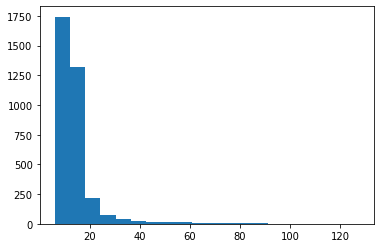

In [13]:
plt.hist(train_errors,bins=20)
train_errors.mean() + 3 * train_errors.std()

35.457564931620695

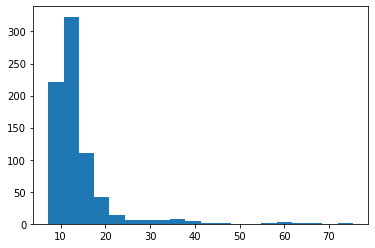

In [14]:
plt.hist(validation_errors,bins=20)
validation_errors.mean() + 3 * validation_errors.std()

43.59576291464789

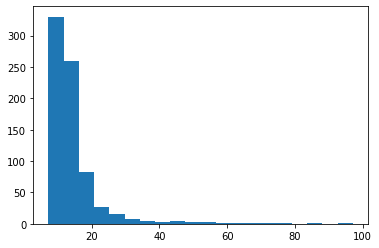

In [15]:
plt.hist(test_errors,bins=20)
test_errors.mean() + 3 * test_errors.std()

In [104]:
val_y.values[validation_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [105]:
test_y.values[test_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       0])

In [106]:
train_y.values[train_errors >= validation_errors.mean() + 3 * validation_errors.std()]

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0])

In [ ]:
# class AnomalyScoreProcessor(nn.Module):

#     def __init__(self, autoencoder, autoencoder_latent_dim, hidden_layer_dim, device):
#         super(AnomalyScoreProcessor, self).__init__()
#         self.autoencoder = autoencoder
#         for param in autoencoder.parameters():
#             param.requires_grad = False
#         self.hidden_layer_dim = hidden_layer_dim
#         self.hidden_layer = torch.nn.Linear(autoencoder_latent_dim + 1 , hidden_layer_dim).to(device)
#         self.relu = torch.nn.ReLU().to(device)
#         self.loss = nn.L1Loss(reduction='sum').to(device)

#     def forward(self, x):
#         z, out =  self.autoencoder(x)
#         anomaly_score = torch.abs(self.loss(out, x))
#         concatenated_tensor = torch.cat((z, anomaly_score.reshape(1, 1)), dim=1)
#         h = self.hidden_layer(concatenated_tensor)
#         rel = self.relu(h)
#         return rel

# class ExtendedAnomalyDetector(nn.Module):
    
#     def __init__(self, anomaly_score_processor, anomaly_score_processor_dim, class_nr, device):
#         super(ExtendedAnomalyDetector, self).__init__()
#         self.anomaly_score_processor = anomaly_score_processor
#         self.output_layer = torch.nn.Linear(anomaly_score_processor_dim, class_nr).to(device)
#         self.softmax = torch.nn.Softmax().to(device)
        
    
#     def forward(self, x):
#         out = self.anomaly_score_processor(x)
#         h = self.output_layer(out)
#         return self.softmax(h)
   

In [ ]:
# asp = AnomalyScoreProcessor(model, 8, 4, device)
# ead = ExtendedAnomalyDetector(asp, 4, 2, device)

In [ ]:
# def train_extended_anomaly_detector(model, x_train, y_train, x_val, y_val, n_epochs):
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
#     criterion = nn.CrossEntropyLoss().to(device)
#     history = dict(train=[], val=[])
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_loss = 10000.0
#     for epoch in range(1, n_epochs + 1):
#         model = model.train()
#         train_losses = []
#         for seq, y in zip(x_train, y_train):
#             optimizer.zero_grad()
#             seq = seq.to(device)
#             pred = model(seq)
#             #print(y)
#             loss = criterion(pred, torch.tensor(y).reshape(1).to(device))
#             loss.backward()
#             optimizer.step()
#             train_losses.append(loss.item())
#         val_losses = []
#         model = model.eval()
#         with torch.no_grad():
#             for seq, y in zip(x_val, y_val):
#                 seq = seq.to(device)
#                 pred = model(seq)
#                 class_val = int(y>1)
#                 loss = criterion(pred, torch.tensor(class_val).reshape(1).to(device))
#                 val_losses.append(loss.item())
#         train_loss = np.mean(train_losses)
#         val_loss = np.mean(val_losses)
#         history['train'].append(train_loss)
#         history['val'].append(val_loss)
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model_wts = copy.deepcopy(model.state_dict())
#         print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')
#     model.load_state_dict(best_model_wts)
#     return model.eval(), history

## Initial baseline

In [107]:
anomaly_threshold = train_errors.mean() + 3 * train_errors.std()
loss_f = torch.nn.L1Loss(reduction='sum').to(device)
model = model.eval()
losses = []
zs = []
training_y = []
with torch.no_grad():
    for seq_true in train_dataset:
        seq_true = seq_true.to(device)
        z, seq_pred = model(seq_true)
        loss = loss_f(seq_pred, seq_true)
        losses.append(loss.cpu().numpy())
        zs.append(z.cpu().numpy().reshape(-1))

In [108]:
indices = np.argsort(losses)
sorted_losses = [losses[i] for i in indices]

In [109]:
i = len(sorted_losses) - 1 
while sorted_losses[i] > anomaly_threshold:
    i-=1
anomalies_cnt = len(sorted_losses) - 1 - i
normal_data_index = i - anomalies_cnt
normal_indices = indices[normal_data_index:i]
anomaly_indices = indices[i:]

artificial_train_dataset_X=[]
artificial_train_dataset_X_numpy=[]
artificial_train_dataset_y=[]
labels = []

for idx in normal_indices:
    complete_vector = np.hstack([zs[idx],losses[idx]])
    vector = zs[idx]
    artificial_train_dataset_X_numpy.append(vector)
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(0)
    labels.append(train_y.iloc[idx])

for idx in anomaly_indices:
    complete_vector = np.hstack([zs[idx],losses[idx]])
    vector = zs[idx]
    artificial_train_dataset_X_numpy.append(vector)
    artificial_train_dataset_X.append(train_dataset[idx])
    artificial_train_dataset_y.append(1)
    labels.append(train_y.iloc[idx])
artificial_train_dataset_y = pd.Series(artificial_train_dataset_y)

artificial_train_dataset_X_numpy = np.array(artificial_train_dataset_X_numpy)
artificial_train_dataset_y = np.array(artificial_train_dataset_y)
artificial_train_dataset_X_numpy_backup = artificial_train_dataset_X_numpy.copy()
artificial_train_dataset_y_backup = artificial_train_dataset_y.copy()

In [110]:
pd.Series(artificial_train_dataset_y).value_counts()

1    82
0    81
dtype: int64

In [ ]:
#train_extended_anomaly_detector(ead, artificial_train_dataset_X, artificial_train_dataset_y, val_dataset, val_y,50)

In [ ]:
# preds = []
# ead = ead.eval()
# with torch.no_grad():    
#     for seq in artificial_train_dataset_X:
#         seq = seq.to(device)
#         pred = ead(seq)
#         pred = np.argmax(pred.cpu().numpy())
#         preds.append(pred)
# preds = pd.Series(preds)
# sum(artificial_train_dataset_y == preds)/len(preds)

# Classical models

In [111]:
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score, recall_score, precision_score, f1_score

In [112]:
artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()

In [113]:
def evaluate(classical_model, dataset_x, dataset_y, verbose = True):
    pred = classical_model.predict_proba(dataset_x)
    preds = np.argmax(pred,axis=1)

    auprc = average_precision_score(dataset_y, np.max(pred, axis=1))
    auroc = roc_auc_score(dataset_y, np.max(pred, axis=1))
    recall = recall_score(dataset_y, np.argmax(pred, axis=1))
    f1 = f1_score(dataset_y, np.argmax(pred, axis=1))
    precision = precision_score(dataset_y, np.argmax(pred, axis=1))
    if verbose:
        print(f'Recall: {recall}, precision: {precision}, f1: {f1_score}')
        print(f'AUROC: {auroc}, AUPRC {auprc}')
    return recall, precision, auroc, auprc, f1

def evaluate_all(classical_model,
                 artificial_train_dataset_X, artificial_dataset_y,
                 train_dataset_X, train_dataset_y,
                 val_dataset_X, val_dataset_y,
                 test_dataset_X, test_dataset_y,
                 iteration_number = 0
                ):
    results = []
    dataset_types = ['artificial_train', 'train', 'val', 'test']
    datasets = [(artificial_train_dataset_X, artificial_train_dataset_y),
                (train_dataset_X, train_dataset_y), (val_dataset_X, val_dataset_y),
                (test_dataset_X, test_dataset_y)]
    for dataset_type, (x, y) in zip(dataset_types, datasets):
        recall, prec, auroc, auprc, f1 = evaluate(classical_model, x, y, verbose=False)
        results.append({'dataset_type': dataset_type, 'recall': recall,'precision': prec, 'auroc': auroc, 'auprc': auprc, 'f1': f1, 'iteration': iteration_number})
    return pd.DataFrame(results)

## LSTM-AD

In [24]:
validation_errors.mean() + 3 * validation_errors.std()

35.457564931620695

In [17]:
dfs = []
for anomaly_threshold in np.linspace(validation_errors.mean(), validation_errors.mean() + 4 * validation_errors.std(), num=1000):
    train_pred = np.array(train_errors) > anomaly_threshold
    val_pred = np.array(validation_errors) > anomaly_threshold
    test_pred = np.array(test_errors) > anomaly_threshold

    df = pd.DataFrame([
        {'dataset_type': 'train', 'recall': recall_score(train_y, train_pred), 'precision': precision_score(train_y, train_pred), 'f1': f1_score(train_y, train_pred)},
        {'dataset_type': 'val', 'recall': recall_score(val_y, val_pred), 'precision': precision_score(val_y, val_pred), 'f1': f1_score(train_y, train_pred)},
        {'dataset_type': 'test', 'recall': recall_score(test_y, test_pred), 'precision': precision_score(test_y, test_pred), 'f1': f1_score(train_y, train_pred)},


    ])
    df['threshold'] = anomaly_threshold
    dfs.append(df)
df = pd.concat(dfs)

In [21]:
df[df.dataset_type=='test'].sort_values(by='f1')

,dataset_type,recall,precision,f1,threshold
2,test,0.105263,0.300000,0.213333,42.208958
2,test,0.105263,0.300000,0.213333,42.006777
2,test,0.105263,0.300000,0.213333,42.035660
2,test,0.105263,0.300000,0.213333,42.064543
2,test,0.105263,0.300000,0.213333,42.093426
...,...,...,...,...,...
2,test,0.210526,0.222222,0.275862,24.185988
2,test,0.210526,0.226415,0.276498,24.272637
2,test,0.210526,0.226415,0.276498,24.243754
2,test,0.210526,0.222222,0.276498,24.214871


In [187]:
test_lstm_series = df.iloc[2, 1:]
test_lstm_series.name='LSTM Autoencoder'
test_lstm_series

recall       0.206897
precision    0.444444
f1           0.223776
Name: LSTM Autoencoder, dtype: object

In [126]:
classical_models = []

## SVM

In [127]:
from sklearn.svm import SVC
classical_model = SVC(probability=True, class_weight={0:1, 1: 10})
classical_models.append(('SVM', classical_model))

## KNN

In [128]:
from sklearn.neighbors import KNeighborsClassifier
classical_model = KNeighborsClassifier(n_neighbors=4)
classical_models.append(('KNN', classical_model))

## LogisticRegression


In [129]:
from sklearn.linear_model import LogisticRegression
classical_model = LogisticRegression(max_iter=100)
classical_models.append(('LogReg', classical_model))

## Decision tree

In [130]:
from sklearn.tree import DecisionTreeClassifier
classical_model = DecisionTreeClassifier(max_depth=5)
classical_models.append(('DT', classical_model))

## Naive Bayes

In [131]:
from sklearn.naive_bayes import GaussianNB
classical_model = GaussianNB()
classical_models.append(('GNB', classical_model))

# Active learning loop

In [132]:
AL_BATCH_SIZE = 10
iterations = 30
repeats = 20

In [136]:
results = pd.DataFrame()
for model_type, model in classical_models:
    for repeat in range(repeats):
        model = sklearn.base.clone(model)
        np.random.seed(repeat)

        artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
        artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()
        model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
        res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                           train_dataset_np, train_y, val_dataset_np, val_y,
                           test_dataset_np, test_y)
        res['model_type'] = model_type
        results.append(res)
        for iteration in range(1, iterations):
            scores = model.predict_proba(train_dataset_np)
            indices = np.argsort(np.abs(scores[:,0] - scores[:, 1]))
            to_query = indices[:AL_BATCH_SIZE]
            new_X = train_dataset_np[to_query]
            new_y = np.array(train_y)[to_query]

            artificial_train_dataset_X_numpy = np.vstack([artificial_train_dataset_X_numpy, new_X])
            artificial_train_dataset_y = np.hstack([artificial_train_dataset_y, new_y])
            model.fit(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
            res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                               train_dataset_np, train_y, val_dataset_np, val_y,
                               test_dataset_np, test_y,
                               iteration          
                    )
            res['model_type'] = model_type
            res['repeat'] = repeat
            results = results.append(res)

In [137]:
results[results.dataset_type == 'test'].sort_values(by='f1')

,dataset_type,recall,precision,auroc,auprc,f1,iteration,model_type,repeat
3,test,0.051724,0.750000,0.217934,0.046723,0.096774,18,SVM,3
3,test,0.068966,0.666667,0.268213,0.052531,0.125000,24,SVM,5
3,test,0.206897,0.110092,0.598988,0.124996,0.143713,2,DT,9
3,test,0.224138,0.119266,0.541085,0.105246,0.155689,1,SVM,15
3,test,0.224138,0.119266,0.564655,0.097798,0.155689,1,SVM,17
...,...,...,...,...,...,...,...,...,...
3,test,0.534483,0.775000,0.262532,0.056152,0.632653,28,GNB,13
3,test,0.534483,0.775000,0.262532,0.056152,0.632653,28,GNB,18
3,test,0.534483,0.775000,0.262532,0.056152,0.632653,28,GNB,0
3,test,0.534483,0.775000,0.262532,0.056152,0.632653,28,GNB,5


In [121]:
res_summarised

,precision,recall,f1
model_type,,,
NB,0.694444,0.431034,0.531915
LogReg,0.583333,0.362069,0.446809
SVM,0.772727,0.293103,0.425000
KNN,0.750000,0.206897,0.324324
DT,0.236842,0.310345,0.268657


In [118]:
res_summarised = results[(results.iteration == 29)&(results.dataset_type=='test')].groupby(['model_type']).mean().sort_values(by='f1',ascending=False)[['precision','recall','f1']]

In [119]:
res_summarised.append(test_lstm_series)

NameError: name 'test_lstm_series' is not defined

In [ ]:
res_summarised

In [ ]:
res_summarised.append(pd.Series())

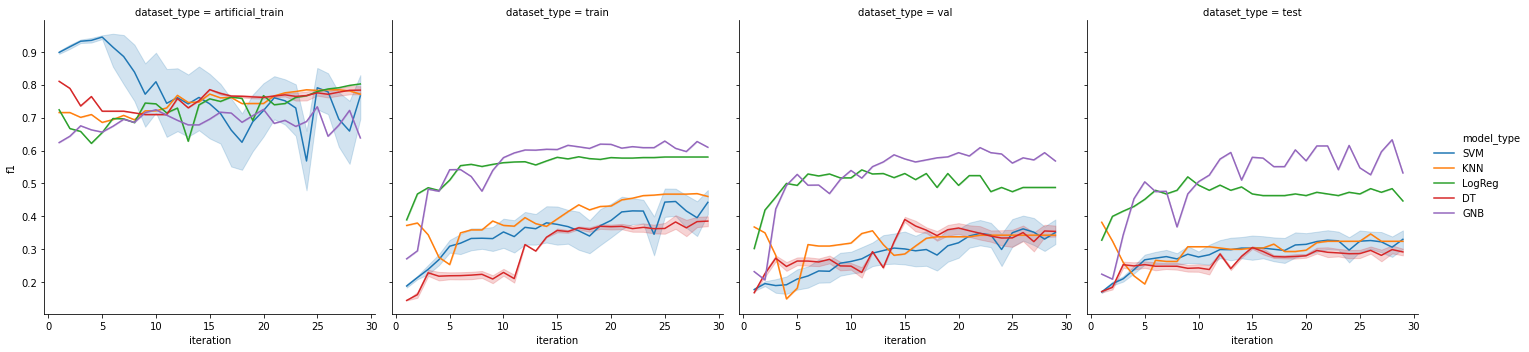

In [138]:
seaborn.relplot(data= results, x='iteration',y='f1', col='dataset_type', hue='model_type', kind='line')

In [80]:
results.to_csv('results_without_resample.csv')

In [117]:
results = pd.read_csv('results_without_resample.csv', index_col=0)

## Imbalanced AL

In [28]:
resamplers = []

### Undersampling

In [29]:
from imblearn.under_sampling import (CondensedNearestNeighbour, EditedNearestNeighbours, RepeatedEditedNearestNeighbours,
                                     AllKNN, InstanceHardnessThreshold, NearMiss, NeighbourhoodCleaningRule,
                                     TomekLinks, OneSidedSelection, RandomUnderSampler)
model = CondensedNearestNeighbour()
resamplers.append(('CondensedNN', model))
model = EditedNearestNeighbours()
resamplers.append(('EditedNN', model))
model = RepeatedEditedNearestNeighbours()
resamplers.append(('RepeatedEditedNN', model))
model = AllKNN(n_neighbors=3)
resamplers.append(('AllKNN', model))
model = InstanceHardnessThreshold()
resamplers.append(('InstantHardnessThreshold', model))
model = NearMiss()
resamplers.append(('NearMiss', model))
model = NeighbourhoodCleaningRule()
resamplers.append(('NeighbourCleaningRule', model))
model = TomekLinks()
resamplers.append(('TomekLinks', model))
model = OneSidedSelection()
resamplers.append(('OneSidedSelection', model))
model = RandomUnderSampler()
resamplers.append(('RandomUnderSampler', model))
model = RandomUnderSampler(replacement=True)
resamplers.append(('RandomUnderSamplerReplacement', model))

undersampling = set([r for r,_ in resamplers])


### Oversampling

In [30]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, KMeansSMOTE, RandomOverSampler, SMOTE, SVMSMOTE
model = BorderlineSMOTE()
resamplers.append(('BorderlineSMOTE',model))
model = RandomOverSampler()
resamplers.append(('RandomOverSampler', model))
model = SMOTE()
resamplers.append(('SMOTE', model))
model = SVMSMOTE()
resamplers.append(('SVMSMOTE', model))

oversampling = set([r for r,_ in resamplers]) - undersampling

### Imbalanced Active learning

In [31]:
artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()
AL_BATCH_SIZE = 10
iterations = 30
repeats = 20 

NameError: name 'artificial_train_dataset_X_numpy_backup' is not defined

In [144]:
results_imbalanced = pd.DataFrame()
for resampler_type, resampler in resamplers:
    for model_type, model in classical_models:
        print(f'Resampler: {resampler_type}, model type: {model_type}')
        for repeat in range(repeats):
            model = sklearn.base.clone(model)
            np.random.seed(repeat)
            artificial_train_dataset_X_numpy = artificial_train_dataset_X_numpy_backup.copy()
            artificial_train_dataset_y = artificial_train_dataset_y_backup.copy()
            X, y = resampler.fit_resample(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
            model.fit(X, y)
            res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                               train_dataset_np, train_y, val_dataset_np, val_y,
                               test_dataset_np, test_y)
            res['model_type'] = model_type
            res['resampler_type'] = resampler_type
            res['repeat'] = repeat
            results_imbalanced = results_imbalanced.append(res)
            for iteration in range(1, iterations):
                scores = model.predict_proba(train_dataset_np)
                indices = np.argsort(np.abs(scores[:,0] - scores[:, 1]))
                to_query = indices[:AL_BATCH_SIZE]
                new_X = train_dataset_np[to_query]
                new_y = np.array(train_y)[to_query]

                artificial_train_dataset_X_numpy = np.vstack([artificial_train_dataset_X_numpy, new_X])
                artificial_train_dataset_y = np.hstack([artificial_train_dataset_y, new_y])
                X, y = resampler.fit_resample(artificial_train_dataset_X_numpy, artificial_train_dataset_y)
                model.fit(X, y)
                res = evaluate_all(model, artificial_train_dataset_X_numpy, artificial_train_dataset_y,
                                   train_dataset_np, train_y, val_dataset_np, val_y,
                                   test_dataset_np, test_y,
                                   iteration          
                        )
                res['model_type'] = model_type
                res['resampler_type'] = resampler_type
                res['repeat'] = repeat
                results_imbalanced = results_imbalanced.append(res)

Resampler: CondensedNN, model type: SVM


/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/data/FIT/lstm-ad/.venv/lib/python3.8/site-packages/sklearn/metrics/_classi

Resampler: CondensedNN, model type: KNN
Resampler: CondensedNN, model type: LogReg
Resampler: CondensedNN, model type: DT
Resampler: CondensedNN, model type: GNB
Resampler: EditedNN, model type: SVM
Resampler: EditedNN, model type: KNN
Resampler: EditedNN, model type: LogReg
Resampler: EditedNN, model type: DT
Resampler: EditedNN, model type: GNB
Resampler: RepeatedEditedNN, model type: SVM
Resampler: RepeatedEditedNN, model type: KNN
Resampler: RepeatedEditedNN, model type: LogReg
Resampler: RepeatedEditedNN, model type: DT
Resampler: RepeatedEditedNN, model type: GNB
Resampler: AllKNN, model type: SVM
Resampler: AllKNN, model type: KNN
Resampler: AllKNN, model type: LogReg
Resampler: AllKNN, model type: DT
Resampler: AllKNN, model type: GNB
Resampler: InstantHardnessThreshold, model type: SVM
Resampler: InstantHardnessThreshold, model type: KNN
Resampler: InstantHardnessThreshold, model type: LogReg
Resampler: InstantHardnessThreshold, model type: DT
Resampler: InstantHardnessThresho

In [61]:
oversampling


{'BorderlineSMOTE', 'RandomOverSampler', 'SMOTE', 'SVMSMOTE'}

In [62]:
undersampling

{'AllKNN',
 'CondensedNN',
 'EditedNN',
 'InstantHardnessThreshold',
 'NearMiss',
 'NeighbourCleaningRule',
 'OneSidedSelection',
 'RandomUnderSampler',
 'RandomUnderSamplerReplacement',
 'RepeatedEditedNN',
 'TomekLinks'}

In [36]:
import seaborn
seaborn.set(font_scale=1.7)
seaborn.set_style("whitegrid")

In [26]:
results_imbalanced = pd.read_csv('results_imbalanced.csv', index_col = 0)

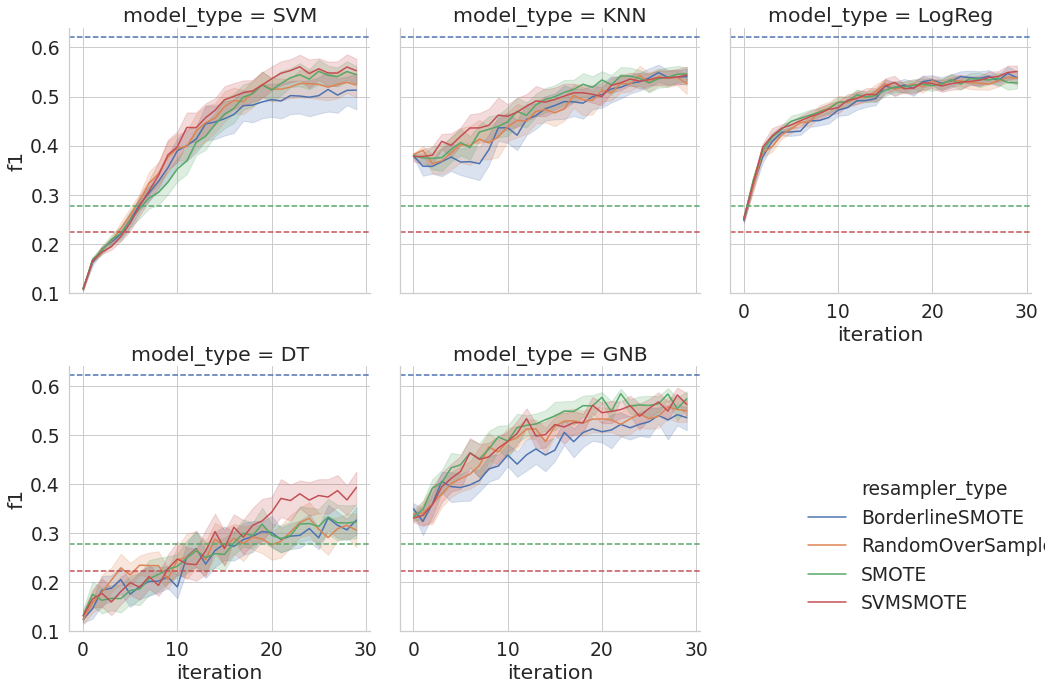

In [37]:
## undersamling

fg = seaborn.relplot(data= results_imbalanced[(results_imbalanced.dataset_type=='test')&(results_imbalanced.resampler_type.isin(oversampling))],
                     x='iteration',y='f1', col='model_type', hue='resampler_type', kind='line', col_wrap=3)
for ax in fg.axes.flat:
    ax.axhline(y=0.223776, linestyle='--', c='r')
    ax.axhline(y=0.621359, linestyle='--')
    ax.axhline(y=0.277136, linestyle='--', c='g')
    ax.set_ylim(0.1,0.64)
leg = fg._legend
leg.set_bbox_to_anchor([0.8, 0.2])  # coordinates of lower left of bounding box
fg.savefig('oversampling.pdf')

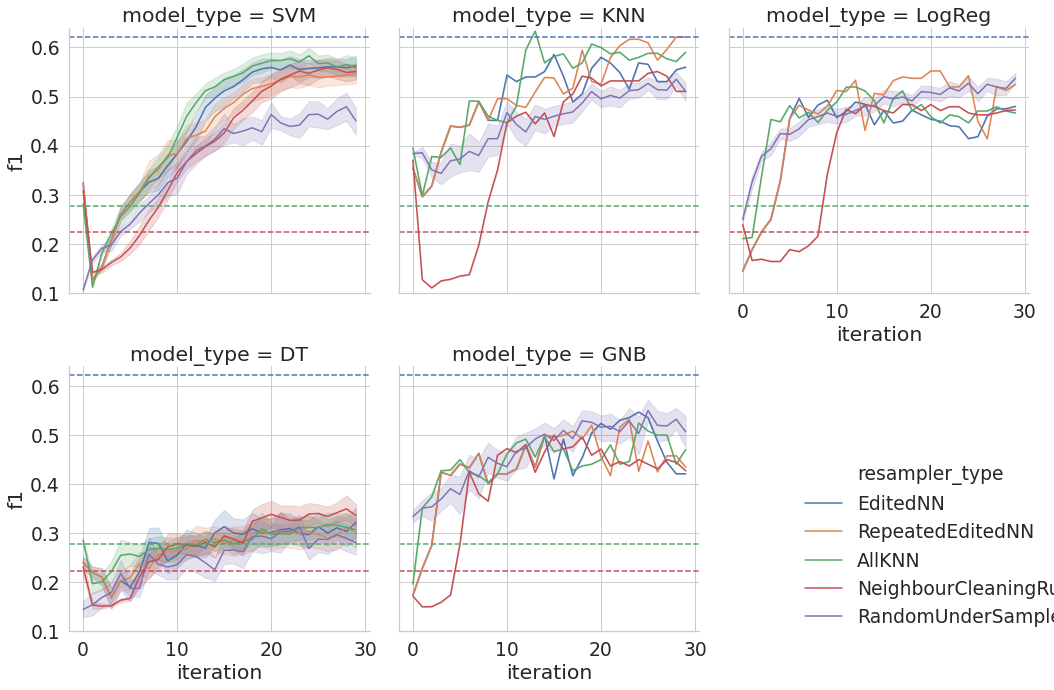

In [38]:
## undersamling

fg = seaborn.relplot(data= results_imbalanced[(results_imbalanced.dataset_type=='test')&(results_imbalanced.resampler_type.isin(list(undersampling_best)))],
                     x='iteration',y='f1', col='model_type', hue='resampler_type', kind='line', col_wrap=3)
for ax in fg.axes.flat:
    ax.axhline(y=0.223776, linestyle='--', c='r')
    ax.axhline(y=0.621359, linestyle='--')
    ax.axhline(y=0.277136, linestyle='--', c='g')
    
    ax.set_ylim(0.1,0.64)
leg = fg._legend
leg.set_bbox_to_anchor([0.8, 0.2])  # coordinates of lower left of bounding box
fg.savefig('undersampling.pdf')

In [34]:
undersampling_best = {'RepeatedEditedNN', 'AllKNN','RandomUnderSampler','NeighbourCleaningRule','EditedNN'}

In [51]:
pd.options.display.max_rows = 100

In [159]:
#results_imbalanced.to_csv('results_imbalanced.csv')

In [85]:
results_imbalanced[(results_imbalanced.iteration == 29)&(results_imbalanced.dataset_type=='test')&(results_imbalanced.resampler_type.isin(undersampling))].groupby(['resampler_type']).mean().sort_values(by='f1',ascending=False)[['precision','recall','f1']]

,precision,recall,f1
resampler_type,,,
RepeatedEditedNN,0.477646,0.539138,0.485912
AllKNN,0.481786,0.513448,0.478625
EditedNN,0.512833,0.454138,0.469046
InstantHardnessThreshold,0.430539,0.617931,0.463529
NeighbourCleaningRule,0.479564,0.486034,0.459575
RandomUnderSampler,0.438922,0.527931,0.457146
OneSidedSelection,0.580867,0.382759,0.443970
RandomUnderSamplerReplacement,0.396431,0.546034,0.434827
TomekLinks,0.534029,0.335862,0.391101


In [115]:
results_imbalanced[(results_imbalanced.iteration == 29)&
                   (results_imbalanced.dataset_type=='test')&
                   (results_imbalanced.resampler_type.isin(list(undersampling_best)+list(oversampling)))
                  ].groupby(['model_type','resampler_type']).mean().sort_values(by='f1',ascending=False)[['precision','recall','f1']]

precision    recall        f1
model_type resampler_type                                      
KNN        RepeatedEditedNN        0.711111  0.551724  0.621359
           AllKNN                  0.659574  0.534483  0.590476
GNB        SMOTE                   0.607183  0.548276  0.573902
SVM        EditedNN                0.629775  0.512069  0.562497
GNB        SVMSMOTE                0.577148  0.553448  0.562477
KNN        EditedNN                0.666667  0.482759  0.560000
SVM        AllKNN                  0.607116  0.523276  0.558402
           SVMSMOTE                0.678848  0.468966  0.552598
LogReg     SVMSMOTE                0.612451  0.501724  0.551118
SVM        NeighbourCleaningRule   0.561683  0.546552  0.551104
GNB        RandomOverSampler       0.587219  0.517241  0.549177
SVM        RepeatedEditedNN        0.522591  0.585345  0.547380
KNN        SMOTE                   0.594179  0.506897  0.545947
SVM        SMOTE                   0.692271  0.451724  0.544713
KNN        SVMSMOTE                0.629101  0.481034  0.543589
           BorderlineSMOTE         0.595758  0.499138  0.540700
LogReg     BorderlineSMOTE         0.574127  0.507759  0.538432
           RandomOverSampler       0.596567  0.489655  0.537582
           RandomUnderSampler      0.565845  0.512931  0.537453
GNB        BorderlineSMOTE         0.524991  0.558621  0.535324
LogReg     SMOTE                   0.589723  0.478448  0.528047
KNN        RandomOverSampler       0.585108  0.483621  0.526287
LogReg     RepeatedEditedNN        0.500000  0.551724  0.524590
SVM        RandomOverSampler       0.671502  0.432759  0.523406
           BorderlineSMOTE         0.693771  0.413793  0.513110
KNN        NeighbourCleaningRule   0.666667  0.413793  0.510638
           RandomUnderSampler      0.580187  0.456897  0.510465
GNB        RandomUnderSampler      0.492387  0.531897  0.506824
LogReg     EditedNN                0.571429  0.413793  0.480000
           NeighbourCleaningRule   0.500000  0.448276  0.472727
GNB        AllKNN                  0.459016  0.482759  0.470588
LogReg     AllKNN                  0.451613  0.482759  0.466667
SVM        RandomUnderSampler      0.348029  0.655172  0.450630
GNB        RepeatedEditedNN        0.438596  0.431034  0.434783
           NeighbourCleaningRule   0.423729  0.431034  0.427350
           EditedNN                0.428571  0.413793  0.421053
DT         SVMSMOTE                0.322316  0.531034  0.393075
           NeighbourCleaningRule   0.245742  0.590517  0.336058
           BorderlineSMOTE         0.245545  0.512069  0.326643
           SMOTE                   0.242364  0.539655  0.322835
           EditedNN                0.267723  0.448276  0.321679
           AllKNN                  0.231611  0.543966  0.306991
           RandomOverSampler       0.265533  0.412069  0.305889
           RepeatedEditedNN        0.215930  0.575862  0.301448
           RandomUnderSampler      0.208160  0.482759  0.280360

In [53]:
results_imbalanced[(results_imbalanced.iteration == 28)&(results_imbalanced.dataset_type=='test')].groupby(['model_type','resampler_type']).mean().sort_values(by='f1',ascending=False)[['precision','recall','f1']]

precision    recall        f1
model_type resampler_type                                              
KNN        RepeatedEditedNN                0.711111  0.551724  0.621359
GNB        SVMSMOTE                        0.608928  0.559483  0.581676
KNN        AllKNN                          0.638298  0.517241  0.571429
SVM        AllKNN                          0.595872  0.543103  0.565243
           SVMSMOTE                        0.674963  0.481897  0.560283
           EditedNN                        0.628988  0.508621  0.558801
KNN        EditedNN                        0.651163  0.482759  0.554455
GNB        SMOTE                           0.591865  0.524138  0.553735
           RandomOverSampler               0.588341  0.523276  0.552158
SVM        SMOTE                           0.704523  0.455172  0.551186
LogReg     SVMSMOTE                        0.607335  0.501724  0.549063
SVM        NeighbourCleaningRule           0.557364  0.550862  0.549023
LogReg     BorderlineSMOTE                 0.580601  0.518966  0.547289
KNN        SMOTE                           0.593378  0.506897  0.545752
SVM        RepeatedEditedNN                0.509926  0.591379  0.543722
KNN        InstantHardnessThreshold        0.608009  0.492241  0.541676
GNB        BorderlineSMOTE                 0.528764  0.568103  0.541571
KNN        SVMSMOTE                        0.620484  0.480172  0.539855
           BorderlineSMOTE                 0.588173  0.501724  0.539545
           RandomOverSampler               0.604569  0.488793  0.539097
LogReg     RandomOverSampler               0.597240  0.491379  0.538872
KNN        RandomUnderSampler              0.596659  0.487931  0.535502
GNB        RandomUnderSampler              0.508154  0.569828  0.532186
SVM        RandomOverSampler               0.680599  0.437931  0.528942
LogReg     SMOTE                           0.593958  0.476724  0.528641
           InstantHardnessThreshold        0.545221  0.511207  0.526057
           RandomUnderSampler              0.548927  0.489655  0.516592
           TomekLinks                      0.641026  0.431034  0.515464
SVM        BorderlineSMOTE                 0.682373  0.417241  0.512615
LogReg     RepeatedEditedNN                0.492063  0.534483  0.512397
KNN        NeighbourCleaningRule           0.666667  0.413793  0.510638
           OneSidedSelection               0.679418  0.410345  0.509839
           RandomUnderSamplerReplacement   0.581790  0.457759  0.509484
GNB        NearMiss                        0.538462  0.482759  0.509091
LogReg     RandomUnderSamplerReplacement   0.493449  0.521552  0.505297
KNN        CondensedNN                     0.621589  0.420690  0.499514
LogReg     OneSidedSelection               0.650671  0.406034  0.499484
GNB        OneSidedSelection               0.495694  0.501724  0.495771
           InstantHardnessThreshold        0.470016  0.514655  0.488608
           RandomUnderSamplerReplacement   0.437684  0.550000  0.482571
SVM        RandomUnderSampler              0.374106  0.688793  0.479261
           InstantHardnessThreshold        0.357387  0.737931  0.478574
LogReg     EditedNN                        0.558140  0.413793  0.475248
GNB        TomekLinks                      0.466667  0.482759  0.474576
LogReg     NeighbourCleaningRule           0.520833  0.431034  0.471698
           AllKNN                          0.459016  0.482759  0.470588
GNB        RepeatedEditedNN                0.450000  0.465517  0.457627
           NeighbourCleaningRule           0.440678  0.448276  0.444444
KNN        TomekLinks                      0.625000  0.344828  0.444444
GNB        AllKNN                          0.433333  0.448276  0.440678
           EditedNN                        0.428571  0.413793  0.421053
SVM        OneSidedSelection               0.771091  0.292241  0.420066
           RandomUnderSamplerReplacement   0.303773  0.681034  0.416660
KNN        NearMiss                        0.500000  0.344828  0.408163
LogReg    